In [1]:
import pandas as pd
import numpy as np
from Machine_Learning_Tools.sklearn_models import Supervised_Model
from Machine_Learning_Tools.Neural_Networks_Models import cross_val_metrics,multi_layer_perceptron
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats.distributions import uniform,poisson
from Machine_Learning_Tools.plots import barplot1,barplot2,boxplot1,correlogram,pairplot
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook',style='whitegrid',palette='pastel',font_scale=1)
%matplotlib inline

In [17]:
train = pd.read_csv('datasets/Customer_Segmentation/Train.csv')

In [18]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [19]:
train = train.drop('ID',axis=1)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 630.4+ KB


In [21]:
train.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [22]:
train = train.dropna(axis=0) 

In [23]:
numeric = ['Age','Family_Size','Work_Experience']
categorical = list(train.drop(numeric,axis=1).columns)

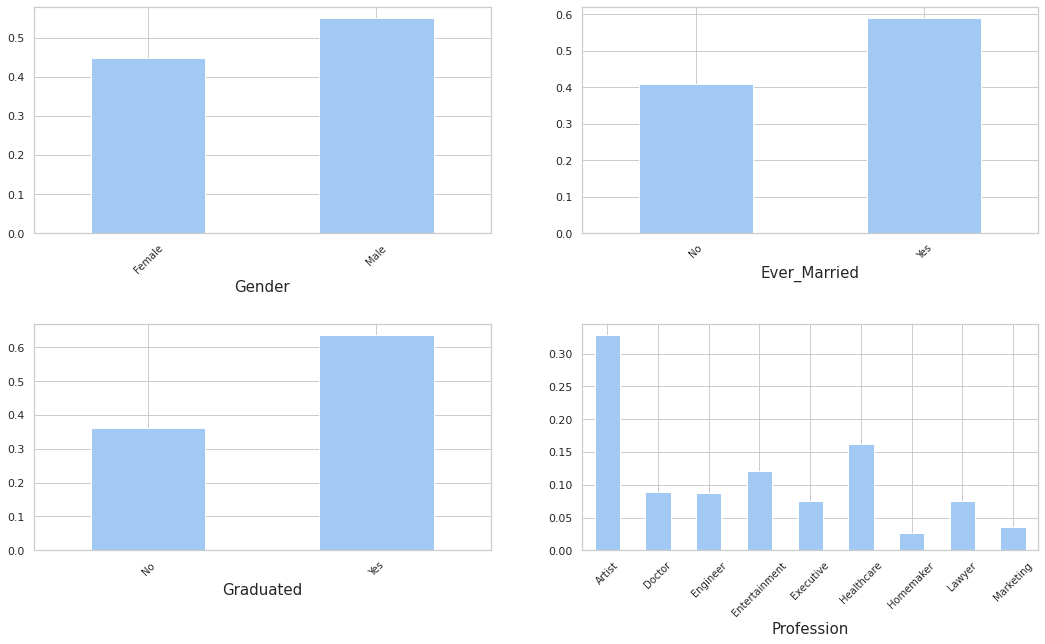

In [24]:
barplot1(train,categorical[:4],2,2,figsize=(18,10))

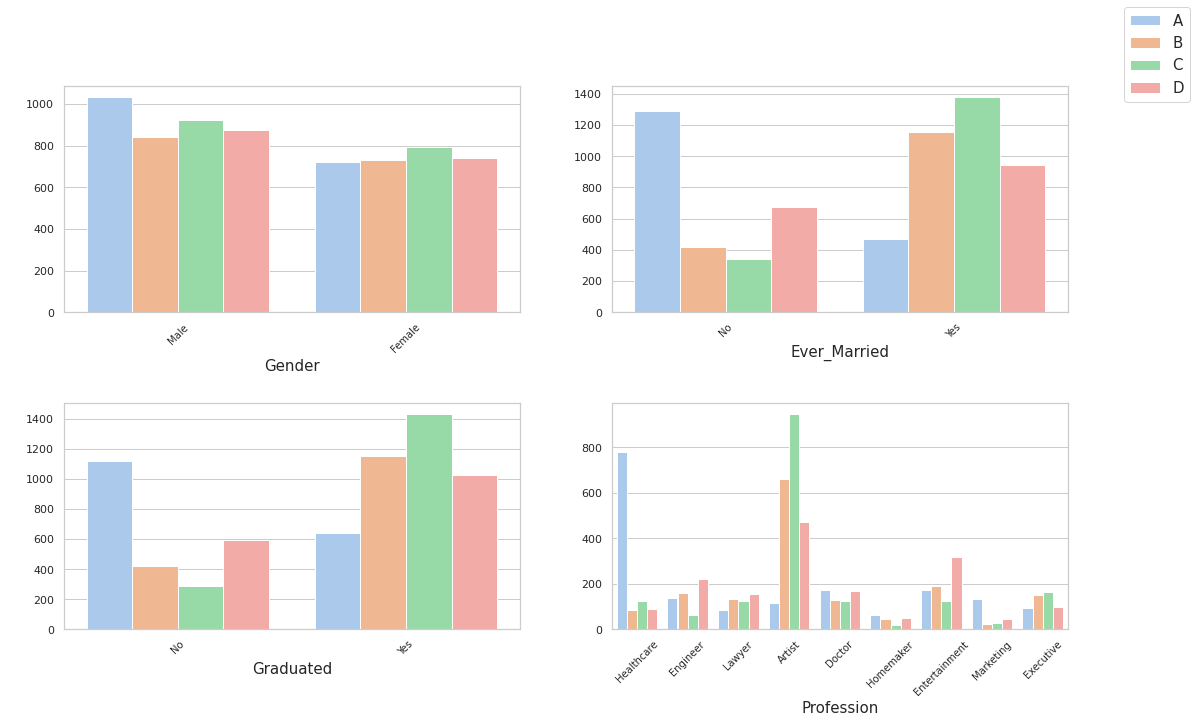

In [25]:
barplot2(train,categorical[:4],'Segmentation',2,2,figsize=(18,10))

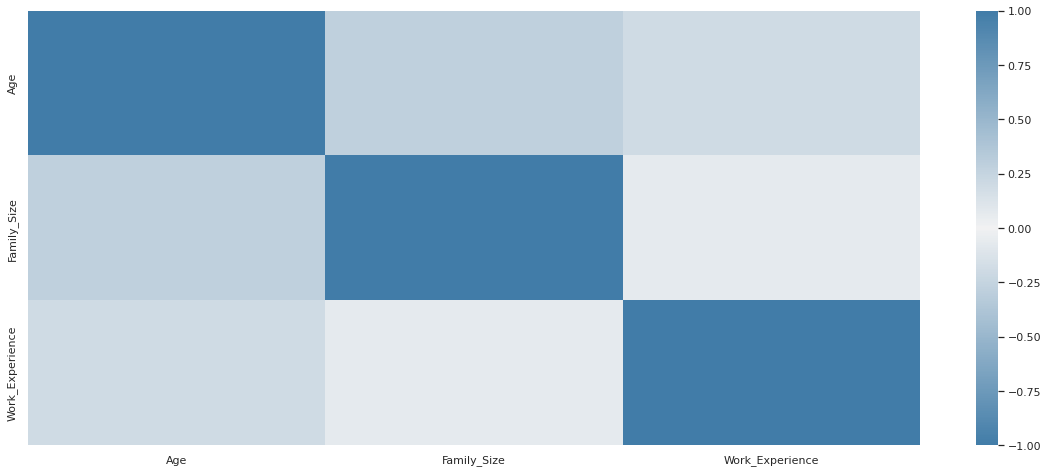

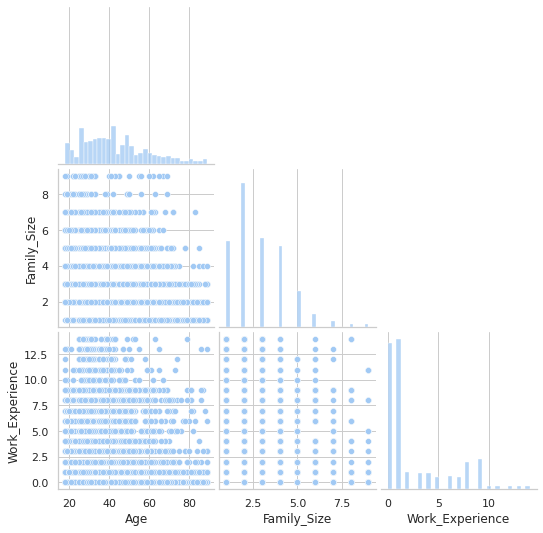

In [26]:
correlogram(train,numeric,figsize=(20,8))

pairplot(train,numeric)

In [27]:
train = pd.get_dummies(train,columns=['Segmentation'])
train['Segmentation'] = np.argmax(train.iloc[:,-4:].values,axis=1)
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation_A,Segmentation_B,Segmentation_C,Segmentation_D,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,0,0,0,1,3
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,0,1,0,0,1
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,0,1,0,0,1
5,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,0,0,1,0,2
6,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,0,0,1,0,2


In [28]:
features = list(train.columns[:-1])
num_features = numeric.copy()
cat_features = categorical[:-1]
target_ohe = list(train.columns[-5:-1])
target = ['Segmentation']

In [29]:
# escalador y onehotencoder para las variables categóricas
scaler = MinMaxScaler()

encoder = OneHotEncoder(drop='first')

features_transformer = ColumnTransformer([
    ('numeric',scaler,num_features),
    ('categorical',encoder,cat_features)
])



# Modelo para la eleccion de variables

model_sel = DecisionTreeClassifier()


feature_selector = SelectFromModel(estimator=model_sel,threshold=0.1)

#Modelos a entrenar

# Suport Vector Machine e hiperparámetros
svm = SVC()
svm_params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4],'coef0':uniform(),'tol':uniform()}
# Random Forest e hiperparámetros

rfm = RandomForestClassifier()

rfm_params = {'n_estimators':poisson(200),'criterion':["gini", "entropy", "log_loss"]}

# **Entrenamiento**

## Random Forest

In [30]:
rf_model = Supervised_Model(train,features,target,rfm,'Random Forest')
#agregamos la transformación
rf_model.add_column_transformer(features_transformer)
#agregammos el selector de variables
rf_model.add_feature_selector(feature_selector)

scoring = 'accuracy'
iters = 10
rf_model.cv_hyperparameter_tuning(rfm_params,iters,scoring)

In [31]:
rf_model.best_score

0.40090765428096764

## SVM

In [33]:
rf_model = Supervised_Model(train,features,target,svm,'SVM')
#agregamos la transformación
rf_model.add_column_transformer(features_transformer)
#agregammos el selector de variables
rf_model.add_feature_selector(feature_selector)

scoring = 'accuracy'
iters = 20
rf_model.cv_hyperparameter_tuning(svm_params,iters,scoring)

In [34]:
rf_model.best_score

0.4352614233423829